# Food Recognition with Mask R-CNN

**Mask R-CNN** is a sophisticated model to implement, especially as compared to a simple or even state-of-the-art deep convolutional neural network model. Instead of developing an implementation of the R-CNN or Mask R-CNN model from scratch, we can use a reliable third-party implementation built on top of the Keras deep learning framework.

The best-of-breed third-party implementations of Mask R-CNN is the [Mask R-CNN Project](https://github.com/matterport/Mask_RCNN) developed by Matterport. The project is open source released under a permissive license (e.g. MIT license) and the code has been widely used on a variety of projects and Kaggle competitions.

### 0. Download Food Recognition data
If you are executing this notebook in colab, you need to download data. Otherwise skip this step.

In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [2]:
if IN_COLAB:
    !git clone https://github.com/gmurro/FoodRecognition.git
    %cd /content/FoodRecognition/src

### 1. Install
The first step is to install the library. The library can be installed directly via pip.

In [3]:
%cd model

C:\Users\peppe\UNIBO\Deep Learning\lab\FoodRecognition\src\model


In [4]:
!git clone https://github.com/akTwelve/Mask_RCNN.git

fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.


In [5]:
%cd Mask_RCNN/

C:\Users\peppe\UNIBO\Deep Learning\lab\FoodRecognition\src\model\Mask_RCNN


In [6]:
import os

if os.name == 'nt':
    !rmdir /Q /S .git
else:
    !rm -r .git

Impossibile trovare il file specificato.


In [9]:
!pip3 install -r requirements.txt

     |████████████████████████████████| 163kB 18.5MB/s 
     |████████████████████████████████| 204kB 41.8MB/s 


In [8]:
!python setup.py install

running install
running bdist_egg
running egg_info
writing mask_rcnn.egg-info\PKG-INFO
writing dependency_links to mask_rcnn.egg-info\dependency_links.txt
writing top-level names to mask_rcnn.egg-info\top_level.txt
reading manifest file 'mask_rcnn.egg-info\SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info\SOURCES.txt'
installing library code to build\bdist.win-amd64\egg
running install_lib
running build_py
creating build\bdist.win-amd64\egg
creating build\bdist.win-amd64\egg\mrcnn
copying build\lib\mrcnn\config.py -> build\bdist.win-amd64\egg\mrcnn
copying build\lib\mrcnn\model.py -> build\bdist.win-amd64\egg\mrcnn
copying build\lib\mrcnn\parallel_model.py -> build\bdist.win-amd64\egg\mrcnn
copying build\lib\mrcnn\utils.py -> build\bdist.win-amd64\egg\mrcnn
copying build\lib\mrcnn\visualize.py -> build\bdist.win-amd64\egg\mrcnn
copying build\lib\mrcnn\__init__.py -> build\bdist.win-amd64\egg\mrcnn
byte-compiling build\bdist.win-amd64\egg\mrc

zip_safe flag not set; analyzing archive contents...


In [9]:
import sys
import os
sys.path.append(os.path.abspath("."))  # To find local version of the library

In [10]:
%cd ../../

C:\Users\peppe\UNIBO\Deep Learning\lab\FoodRecognition\src


### Import libraries 

In [11]:
import tensorflow as tf
print("TF: ",tf.__version__)
print("Keras: ",tf.keras.__version__)

TF:  2.4.1
Keras:  2.4.0


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random

from mrcnn.config import Config
from mrcnn import model as modellib, utils
from mrcnn import visualize

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils

### 2. Configuration
In summary, to train the model on your own dataset you'll need to extend two classes:

- `Config` This class contains the default configuration. Subclass it and modify the attributes you need to change.

- `Dataset` This class provides a consistent way to work with any dataset. It allows you to use new datasets for training without having to change the code of the model. It also supports loading multiple datasets at the same time, which is useful if the objects you want to detect are not all available in one dataset.

In [13]:
class FoodConfig(Config):
    """Configuration for training on the food dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "food"


    # Number of classes (including background)
    NUM_CLASSES = 1 + 273  # Background + objects

   # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 100
    MINI_MASK_SHAPE = (128,128)
    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 20

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5

In [14]:
config = FoodConfig()
config.display()

DATA_DIRECTORY = "../data/"

TRAIN_IMAGES_DIRECTORY = "../data/train/images"
TRAIN_ANNOTATIONS_PATH = "../data/train/annotations.json"

VAL_IMAGES_DIRECTORY = "../data/val/images"
VAL_ANNOTATIONS_PATH = "../data/val/annotations.json"


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                286
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE            

### 3. Dataset
Create a synthetic dataset.

Extend the Dataset class and add a method to load the food dataset, load_foods(), and override the following methods:

- load_image()
- load_mask()
- image_reference()

In [15]:
class FoodDataset(utils.Dataset):
    def load_foods(self, dataset_dir, subset, class_ids=None, return_coco=False):
        """Load a subset of the food dataset.
        dataset_dir: The root directory of the dataset.
        subset: What to load (train, val)
        class_ids: If provided, only loads images that have the given classes.
        return_coco: If True, returns the COCO object.
        """

        # check subset correctness
        if subset != "train" and subset != "val":
          raise Exception("The parameter subset should be 'train' or 'val'.")

        
        coco = COCO(dataset_dir+"train/annotations.json") if subset == "train" else COCO(dataset_dir+"val/annotations.json") 
        image_dir = dataset_dir+"train/images/" if subset == "train" else dataset_dir+"val/images/"

        # Load all classes or a subset?
        if not class_ids:
            # All classes
            class_ids = sorted(coco.getCatIds())

        # All images or a subset?
        if class_ids:
            image_ids = []
            for id in class_ids:
                image_ids.extend(list(coco.getImgIds(catIds=[id])))
            # Remove duplicates
            image_ids = list(set(image_ids))
        else:
            # All images
            image_ids = list(coco.imgs.keys())

        # Add classes
        for i in class_ids:
            self.add_class("food", i, coco.loadCats(i)[0]["name"])

        # Add images
        for i in image_ids:
            self.add_image(
                "food", image_id=i,
                path=os.path.join(image_dir, coco.imgs[i]['file_name']),
                width=coco.imgs[i]["width"],
                height=coco.imgs[i]["height"],
                annotations=coco.loadAnns(coco.getAnnIds(
                    imgIds=[i], catIds=class_ids, iscrowd=None)))
        if return_coco:
            return coco


    def load_mask(self, image_id):
        """Load instance masks for the given image.
        Different datasets use different ways to store masks. This
        function converts the different mask format to one format
        in the form of a bitmap [height, width, instances].
        Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a COCO image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "food":
            return super(FoodDataset, self).load_mask(image_id)

        instance_masks = []
        class_ids = []
        annotations = self.image_info[image_id]["annotations"]
        # Build mask of shape [height, width, instance_count] and list
        # of class IDs that correspond to each channel of the mask.
        for annotation in annotations:
            class_id = self.map_source_class_id(
                "food.{}".format(annotation['category_id']))
            if class_id:
                m = self.annToMask(annotation, image_info["height"],
                                   image_info["width"])
                # Some objects are so small that they're less than 1 pixel area
                # and end up rounded out. Skip those objects.
                if m.max() < 1:
                    continue
                # Is it a crowd? If so, use a negative class ID.
                if annotation['iscrowd']:
                    # Use negative class ID for crowds
                    class_id *= -1
                    # For crowd masks, annToMask() sometimes returns a mask
                    # smaller than the given dimensions. If so, resize it.
                    if m.shape[0] != image_info["height"] or m.shape[1] != image_info["width"]:
                        m = np.ones([image_info["height"], image_info["width"]], dtype=bool)
                instance_masks.append(m)
                class_ids.append(class_id)

        # Pack instance masks into an array
        if class_ids:
            mask = np.stack(instance_masks, axis=2).astype(np.bool)
            class_ids = np.array(class_ids, dtype=np.int32)
            return mask, class_ids
        else:
            # Call super class to return an empty mask
            return super(FoodDataset, self).load_mask(image_id)

    def image_reference(self, image_id):

      """Return the path of the image."""
      info = self.image_info[image_id]
      if info["source"] == "food":
          return info["path"]
      else:
          super(self.__class__, self).image_reference(image_id)


    # The following two functions are from pycocotools with a few changes.

    def annToRLE(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE to RLE.
        :return: binary mask (numpy 2D array)
        """
        segm = ann['segmentation']
        if isinstance(segm, list):
            # polygon -- a single object might consist of multiple parts
            # we merge all parts into one mask rle code
            rles = maskUtils.frPyObjects(segm, height, width)
            rle = maskUtils.merge(rles)
        elif isinstance(segm['counts'], list):
            # uncompressed RLE
            rle = maskUtils.frPyObjects(segm, height, width)
        else:
            # rle
            rle = ann['segmentation']
        return rle

    def annToMask(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE, or RLE to binary mask.
        :return: binary mask (numpy 2D array)
        """
        rle = self.annToRLE(ann, height, width)
        m = maskUtils.decode(rle)
        return m

In [16]:
# Training dataset
dataset_train = FoodDataset()
dataset_train.load_foods(DATA_DIRECTORY, "train")
dataset_train.prepare()                   # Must call before using the dataset

# Validation dataset
dataset_val = FoodDataset()
dataset_val.load_foods(DATA_DIRECTORY, "val")
dataset_val.prepare()

loading annotations into memory...
Done (t=3.67s)
creating index...
index created!
loading annotations into memory...
Done (t=0.26s)
creating index...
index created!


In [17]:
print("Train image Count: {}".format(len(dataset_train.image_ids)))
print("Val image Count: {}".format(len(dataset_val.image_ids)))
print("Class Count: {}".format(dataset_train.num_classes))
for i, info in enumerate(dataset_train.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Train image Count: 24120
Val image Count: 1269
Class Count: 274
  0. BG                                                
  1. beetroot-steamed-without-addition-of-salt         
  2. green-bean-steamed-without-addition-of-salt       
  3. watermelon-fresh                                  
  4. pizza-with-ham-baked                              
  5. pizza-with-vegetables-baked                       
  6. applesauce-unsweetened-canned                     
  7. quiche-with-cheese-baked-with-puff-pastry         
  8. sweet-potato                                      
  9. country-fries                                     
 10. potato-gnocchi                                    
 11. potatoes-steamed                                  
 12. chips-french-fries                                
 13. rosti                                             
 14. vegetable-mix-peas-and-carrots                    
 15. mixed-vegetables                                  
 16. ratatouille                        

### Display Samples
Load and display images and masks.

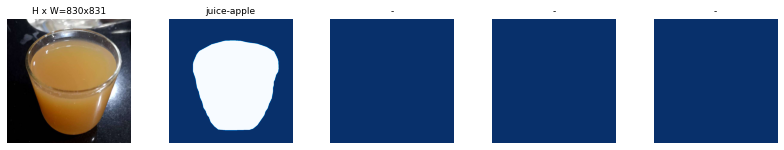

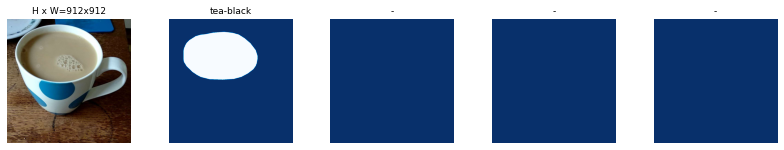

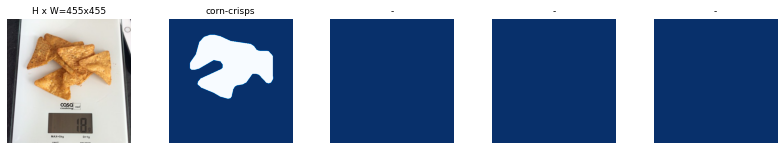

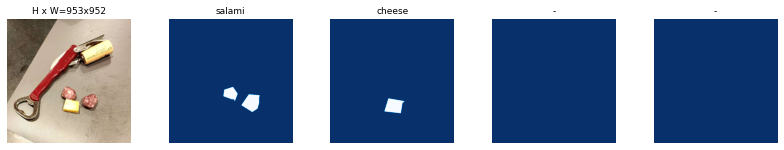

In [18]:
# Load and display random samples
image_ids = np.random.choice(dataset_val.image_ids, 4)
for image_id in image_ids:
    image = dataset_val.load_image(image_id)
    mask, class_ids = dataset_val.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_val.class_names)

image_id  1253 ../data/val/images/073586.jpg


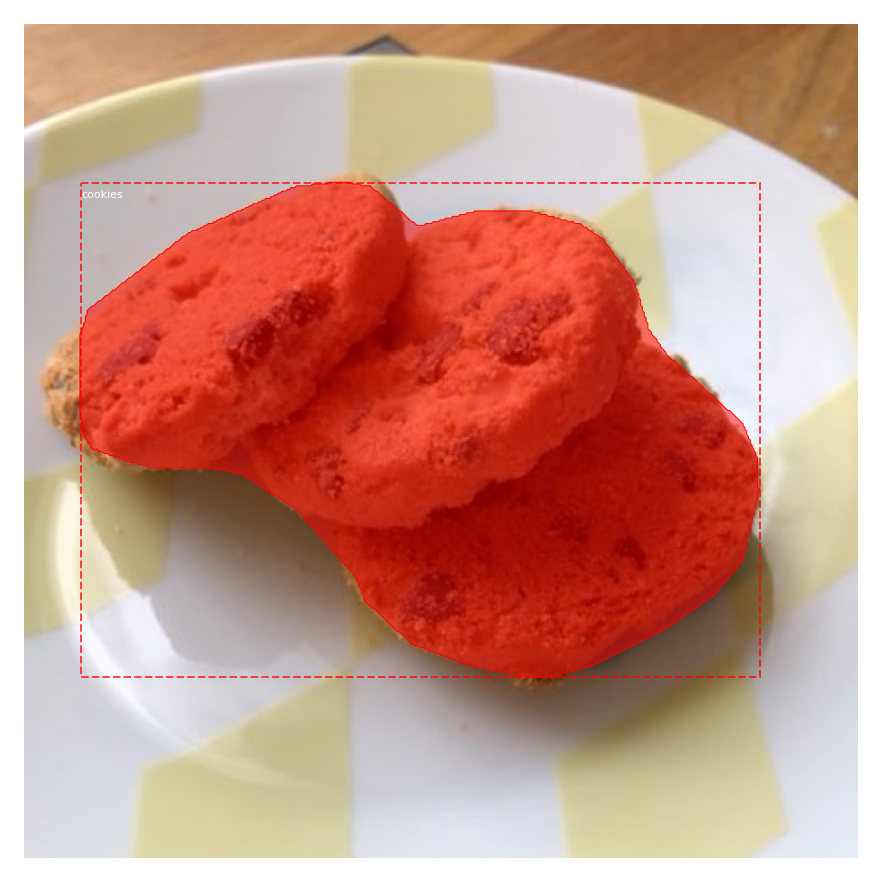

In [19]:
# Load random image and mask.
image_id = random.choice(dataset_val.image_ids)
image = dataset_val.load_image(image_id)
mask, class_ids = dataset_val.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset_val.image_reference(image_id))
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset_val.class_names)

### 4. Create Model

In [20]:
# Directory to save logs and trained model
MODEL_DIR = 'model/mask_rcnn_weights/'

# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

### 5. Training
Train in two stages:

1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass layers='heads' to the train() function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass layers="all to train all layers.

In [22]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: model/mask_rcnn_weights/food20210429T1020\mask_rcnn_food_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_deconv      (Time

C:\Users\peppe\anaconda3\envs\deep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\peppe\anaconda3\envs\deep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\peppe\anaconda3\envs\deep\lib\site-packages\tensorflow\python\framework\indexed_slices.py:435: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training/SGD/gradients/gradients/

 1/20 [>.............................] - ETA: 6:55 - batch: 0.0000e+00 - size: 2.0000 - loss: 68.9113 - rpn_class_loss: 11.4249 - rpn_bbox_loss: 8.6919 - mrcnn_class_loss: 9.9296 - mrcnn_bbox_loss: 3.6379 - mrcnn_mask_loss: 0.7714

C:\Users\peppe\anaconda3\envs\deep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\peppe\anaconda3\envs\deep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 2/20 [==>...........................] - ETA: 14s - batch: 0.5000 - size: 2.0000 - loss: 71.2070 - rpn_class_loss: 11.2107 - rpn_bbox_loss: 9.6698 - mrcnn_class_loss: 8.5528 - mrcnn_bbox_loss: 5.1627 - mrcnn_mask_loss: 1.0076     

C:\Users\peppe\anaconda3\envs\deep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\peppe\anaconda3\envs\deep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 3/20 [===>..........................] - ETA: 10s - batch: 1.0000 - size: 2.0000 - loss: 61.9566 - rpn_class_loss: 8.4933 - rpn_bbox_loss: 9.6458 - mrcnn_class_loss: 6.1540 - mrcnn_bbox_loss: 5.7336 - mrcnn_mask_loss: 0.9515 

C:\Users\peppe\anaconda3\envs\deep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\peppe\anaconda3\envs\deep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 4/20 [=====>........................] - ETA: 8s - batch: 1.5000 - size: 2.0000 - loss: 52.8389 - rpn_class_loss: 6.6579 - rpn_bbox_loss: 8.5983 - mrcnn_class_loss: 4.7384 - mrcnn_bbox_loss: 5.4656 - mrcnn_mask_loss: 0.9592 

C:\Users\peppe\anaconda3\envs\deep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\peppe\anaconda3\envs\deep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 5/20 [======>.......................] - ETA: 8s - batch: 2.0000 - size: 2.0000 - loss: 49.1993 - rpn_class_loss: 5.3504 - rpn_bbox_loss: 8.2431 - mrcnn_class_loss: 4.1777 - mrcnn_bbox_loss: 5.8686 - mrcnn_mask_loss: 0.9599

C:\Users\peppe\anaconda3\envs\deep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\peppe\anaconda3\envs\deep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 6/20 [========>.....................] - ETA: 7s - batch: 2.5000 - size: 2.0000 - loss: 44.3002 - rpn_class_loss: 4.4702 - rpn_bbox_loss: 7.6302 - mrcnn_class_loss: 3.4970 - mrcnn_bbox_loss: 5.6222 - mrcnn_mask_loss: 0.9304

C:\Users\peppe\anaconda3\envs\deep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\peppe\anaconda3\envs\deep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 7/20 [=========>....................] - ETA: 6s - batch: 3.0000 - size: 2.0000 - loss: 41.8228 - rpn_class_loss: 3.8387 - rpn_bbox_loss: 7.2668 - mrcnn_class_loss: 3.1030 - mrcnn_bbox_loss: 5.7779 - mrcnn_mask_loss: 0.9251

C:\Users\peppe\anaconda3\envs\deep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\peppe\anaconda3\envs\deep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 8/20 [===========>..................] - ETA: 5s - batch: 3.5000 - size: 2.0000 - loss: 39.2661 - rpn_class_loss: 3.3695 - rpn_bbox_loss: 6.8198 - mrcnn_class_loss: 2.9508 - mrcnn_bbox_loss: 5.5774 - mrcnn_mask_loss: 0.9155

C:\Users\peppe\anaconda3\envs\deep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\peppe\anaconda3\envs\deep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 9/20 [============>.................] - ETA: 5s - batch: 4.0000 - size: 2.0000 - loss: 37.6157 - rpn_class_loss: 3.0038 - rpn_bbox_loss: 6.5312 - mrcnn_class_loss: 2.7995 - mrcnn_bbox_loss: 5.5728 - mrcnn_mask_loss: 0.9006

C:\Users\peppe\anaconda3\envs\deep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\peppe\anaconda3\envs\deep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


10/20 [==============>...............] - ETA: 4s - batch: 4.5000 - size: 2.0000 - loss: 37.5242 - rpn_class_loss: 2.7219 - rpn_bbox_loss: 6.9255 - mrcnn_class_loss: 2.6803 - mrcnn_bbox_loss: 5.5522 - mrcnn_mask_loss: 0.8823

C:\Users\peppe\anaconda3\envs\deep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\peppe\anaconda3\envs\deep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


11/20 [===============>..............] - ETA: 4s - batch: 5.0000 - size: 2.0000 - loss: 36.3055 - rpn_class_loss: 2.4796 - rpn_bbox_loss: 6.8110 - mrcnn_class_loss: 2.5204 - mrcnn_bbox_loss: 5.4663 - mrcnn_mask_loss: 0.8753

C:\Users\peppe\anaconda3\envs\deep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\peppe\anaconda3\envs\deep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


12/20 [=================>............] - ETA: 3s - batch: 5.5000 - size: 2.0000 - loss: 35.0810 - rpn_class_loss: 2.2757 - rpn_bbox_loss: 6.7990 - mrcnn_class_loss: 2.3338 - mrcnn_bbox_loss: 5.2623 - mrcnn_mask_loss: 0.8697

C:\Users\peppe\anaconda3\envs\deep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\peppe\anaconda3\envs\deep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


13/20 [==================>...........] - ETA: 2s - batch: 6.0000 - size: 2.0000 - loss: 34.7472 - rpn_class_loss: 2.1296 - rpn_bbox_loss: 6.8103 - mrcnn_class_loss: 2.2873 - mrcnn_bbox_loss: 5.2838 - mrcnn_mask_loss: 0.8626

C:\Users\peppe\anaconda3\envs\deep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\peppe\anaconda3\envs\deep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


14/20 [====================>.........] - ETA: 2s - batch: 6.5000 - size: 2.0000 - loss: 33.0164 - rpn_class_loss: 1.9795 - rpn_bbox_loss: 6.4943 - mrcnn_class_loss: 2.1319 - mrcnn_bbox_loss: 5.0531 - mrcnn_mask_loss: 0.8494

C:\Users\peppe\anaconda3\envs\deep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\peppe\anaconda3\envs\deep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


15/20 [=====================>........] - ETA: 2s - batch: 7.0000 - size: 2.0000 - loss: 32.6714 - rpn_class_loss: 1.8511 - rpn_bbox_loss: 6.2781 - mrcnn_class_loss: 2.1220 - mrcnn_bbox_loss: 5.2394 - mrcnn_mask_loss: 0.8451

C:\Users\peppe\anaconda3\envs\deep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\peppe\anaconda3\envs\deep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


16/20 [=======================>......] - ETA: 1s - batch: 7.5000 - size: 2.0000 - loss: 31.5126 - rpn_class_loss: 1.7370 - rpn_bbox_loss: 6.0145 - mrcnn_class_loss: 2.0218 - mrcnn_bbox_loss: 5.1442 - mrcnn_mask_loss: 0.8387

C:\Users\peppe\anaconda3\envs\deep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\peppe\anaconda3\envs\deep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


17/20 [========================>.....] - ETA: 1s - batch: 8.0000 - size: 2.0000 - loss: 30.7626 - rpn_class_loss: 1.6391 - rpn_bbox_loss: 5.8985 - mrcnn_class_loss: 1.9642 - mrcnn_bbox_loss: 5.0459 - mrcnn_mask_loss: 0.8336

C:\Users\peppe\anaconda3\envs\deep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\peppe\anaconda3\envs\deep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


18/20 [==========================>...] - ETA: 0s - batch: 8.5000 - size: 2.0000 - loss: 30.8177 - rpn_class_loss: 1.5548 - rpn_bbox_loss: 6.0689 - mrcnn_class_loss: 1.9393 - mrcnn_bbox_loss: 5.0186 - mrcnn_mask_loss: 0.8272

C:\Users\peppe\anaconda3\envs\deep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\peppe\anaconda3\envs\deep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


19/20 [===========================>..] - ETA: 0s - batch: 9.0000 - size: 2.0000 - loss: 30.1322 - rpn_class_loss: 1.4752 - rpn_bbox_loss: 5.9666 - mrcnn_class_loss: 1.8662 - mrcnn_bbox_loss: 4.9330 - mrcnn_mask_loss: 0.8251

C:\Users\peppe\anaconda3\envs\deep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\peppe\anaconda3\envs\deep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


20/20 [==============================] - ETA: 0s - batch: 9.5000 - size: 2.0000 - loss: 29.8474 - rpn_class_loss: 1.4086 - rpn_bbox_loss: 6.0019 - mrcnn_class_loss: 1.8047 - mrcnn_bbox_loss: 4.8897 - mrcnn_mask_loss: 0.8188

C:\Users\peppe\anaconda3\envs\deep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\peppe\anaconda3\envs\deep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\peppe\anaconda3\envs\deep\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in Te

20/20 [==============================] - 43s 1s/step - batch: 9.5000 - size: 2.0000 - loss: 29.8474 - rpn_class_loss: 1.4086 - rpn_bbox_loss: 6.0019 - mrcnn_class_loss: 1.8047 - mrcnn_bbox_loss: 4.8897 - mrcnn_mask_loss: 0.8188 - val_loss: 27.8145 - val_rpn_class_loss: 0.3536 - val_rpn_bbox_loss: 9.7551 - val_mrcnn_class_loss: 0.3468 - val_mrcnn_bbox_loss: 2.8760 - val_mrcnn_mask_loss: 0.5757


In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=10, 
            layers="all")


Starting at epoch 0. LR=0.0001

Checkpoint Path: model/mask_rcnn_weights/food20210429T0814/mask_rcnn_food_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b   

## 6. Detection


In [23]:
class InferenceConfig(FoodConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Use fn_output_signature instead
Loading weights from  model/mask_rcnn_weights/food20210429T1020\mask_rcnn_food_0001.h5
Re-starting from epoch 1


C:\Users\peppe\anaconda3\envs\deep\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


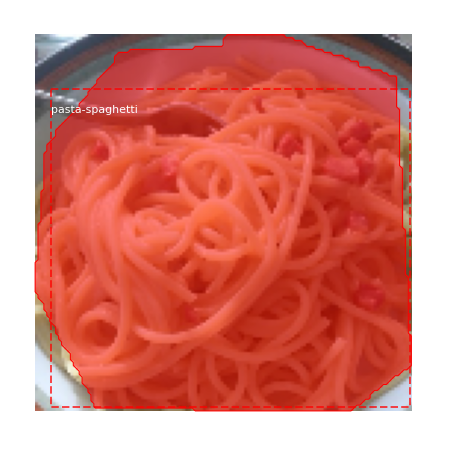

In [35]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id)
'''
print("original_image", original_image)
print("image_meta", image_meta)
print("gt_class_id", gt_class_id)
print("gt_bbox", gt_bbox)
print("gt_mask", gt_mask)'''

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [ ]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax




results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())